In [1]:
#import all necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import time
import re
import os
import patsy
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from mlxtend.plotting import plot_linear_regression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Pokémon Stat Prediction

## Intro

The goal of this code is to pull data from a Kaggle dataset (based off PokemonDB and other sources) and create a predictor for a random pokémon's stats.


In [2]:
#pull data from
raw = pd.read_csv('/Users/randy/Downloads/Pokemon.csv') #Original data

In [3]:
#check that the data looks ok
raw.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
#overview of data
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [5]:
#check for NaN values
raw.isnull().values.any()

True

In [6]:
#find NaN values
nan_rows = raw[raw.isnull().T.any().T]
nan_rows.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False
11,9,Blastoise,Water,NaN,530,79,83,100,85,105,78,1,False


In [7]:
#change all Type 2 NaN values to 0:
raw['Type 2'] = raw['Type 2'].fillna(0)

In [8]:
#check for NaN values again
raw.isnull().values.any()

False

In [9]:
#I only want the numerical values since my rows are so few.
raw1 = raw.drop(columns=['#','Name','Type 1','Type 2','Total','Generation','Legendary'])

In [10]:
#get Z-scores in order to remove outliers
z = np.abs(stats.zscore(raw1))

In [11]:
print(np.where(z > 3))

(array([ 71,  87,  98, 121, 155, 163, 164, 217, 223, 224, 230, 230, 232,
       261, 313, 315, 332, 333, 351, 414, 415, 422, 422, 424, 426, 426,
       429, 429, 430, 431, 456, 473, 544, 545, 655, 789]), array([3, 2, 2, 0, 0, 1, 3, 0, 2, 2, 2, 4, 1, 0, 0, 5, 2, 2, 0, 2, 4, 3,
       4, 1, 1, 3, 1, 3, 4, 5, 2, 0, 0, 0, 0, 2]))


In [12]:
#create the df without outliers
df = raw1[(z < 3).all(axis=1)]

In [13]:
df = df.rename(columns = {'Sp. Atk':'Sp_Atk',
                          'Sp. Def':'Sp_Def',})

# Create a Standardized Set

In [14]:
# Get column names first
names = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']
# df_variables = df.drop(columns=['Defense'])
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(df, columns=names)


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Create a Normalized Set

In [15]:
# Get column names first
names = df.columns
# Create the Scaler object
normalized_df = preprocessing.Normalizer(df)
# Fit your data on the scaler object


# Sets to work with

Alright, so now I have 3 versions of the same data:  
- Original: df
- Standardized/Scaled: scaled_df
- Normalized: normalized_df

In [16]:
test = 'Defense ~ HP + Attack + Sp_Atk + Sp_Def + Speed'

In [17]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(test, data=scaled_df, return_type='dataframe')

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defense   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     123.4
Date:                Sun, 12 May 2019   Prob (F-statistic):           1.15e-95
Time:                        00:41:01   Log-Likelihood:                -3405.0
No. Observations:                 768   AIC:                             6822.
Df Residuals:                     762   BIC:                             6850.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.1540      2.863      8.088      0.000      17.534      28.774
HP            -0.0061      0.043     -0.144      0.886      -0.090       0.078
Attack         0.3720      0.029     12.612      0.000       0.314       0.430
Sp_Atk        -0.0532      0.031     -1.708      0.088      -0.114       0.008
Sp_Def         0.5375      0.035     15.294      0.000       0.468       0.606
Speed         -0.2058      0.030     -6.751      0.000      -0.266      -0.146
==============================================================================
Omnibus:                       93.859   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.631
Skew:                           0.741   Prob(JB):                     5.98e-40
Kurtosis:                       4.857   Cond. No.                         644.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here are my notes on how to read the OLS Regression Results:
 * Dep. Variable - the Y-value. It is the variable acting as the response in the model.
 * Model - The model used in the fit
 * No. Observations - # of observations
 * Df Residuals - degrees of freedom of the residuals (# of obs - # of parameters, usually N-1)
 * Df Model - # of parameters in the model
 * R-squared - (coefficient of determination) A statistical measure of how well the regression line approximates the real data points
 * Adjusted R-squared - R-squared adjusted based on the # of observations and Df Residuals
 * F-statistic - a measure of how significant the fit is
 * Prob (F-statistic) - The probability that you would get the above statistic, given the null hypothesis that they are unrelated
 * Log-Likelihood - the likelihood the model will produce the results we expect. (I think I want this close to 0?)
 * pvalue <= 0.05 means strong evidence against the null hypothesis (you can reject the null hypothesis)
 * pvalue >= 0.05 means not significant; you can't reject the null hypothesis

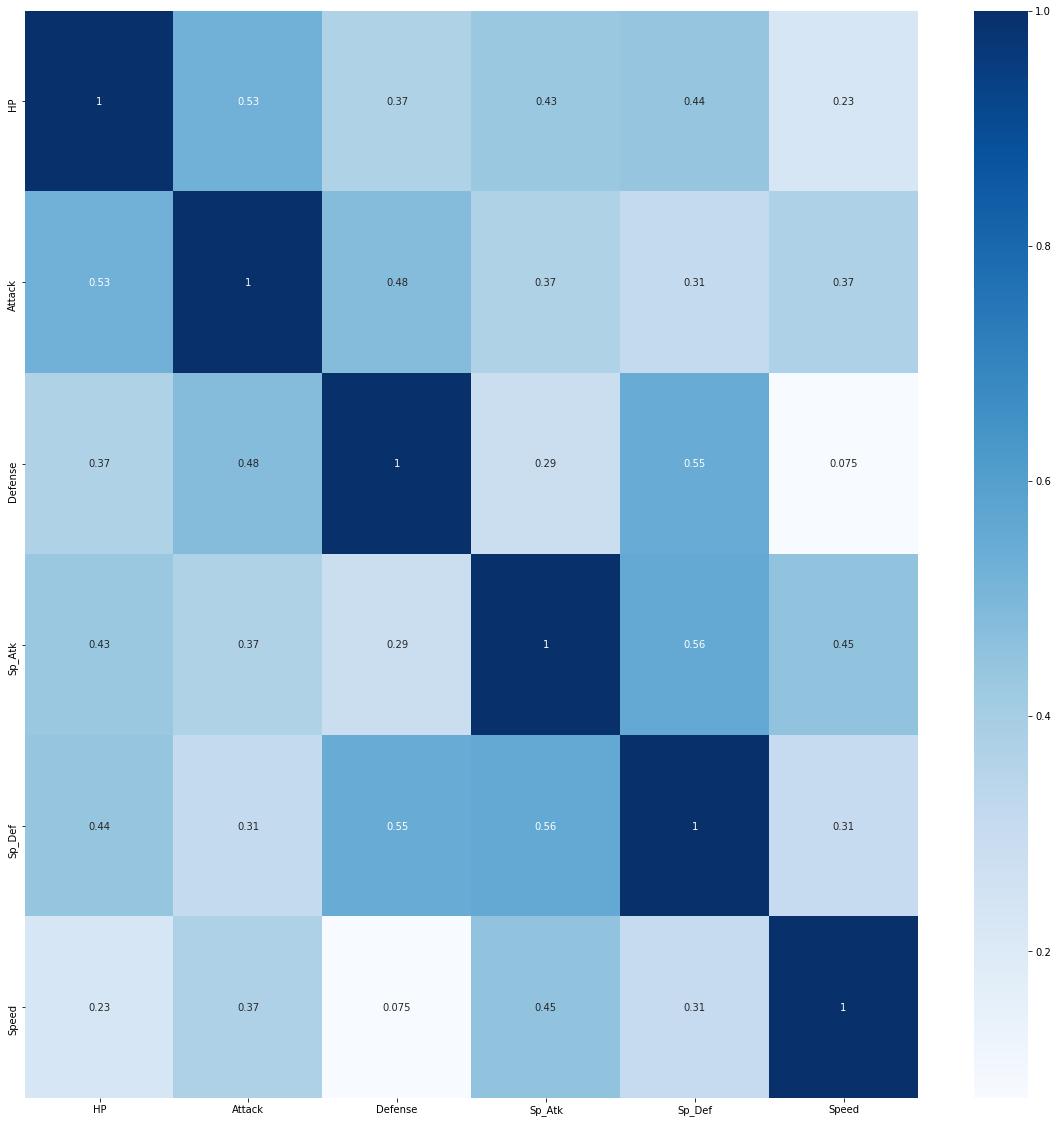

In [18]:
#visualization of any strong collinearity between features
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), cmap="Blues", ax=ax, annot=True)
plt.show()

In [19]:
df.columns

Index(['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed'], dtype='object')

In [20]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:, [1,2,3,4,5]] #takes attack, defense, sp_attack, sp_defense, speed

# Choose the response variable(s)
y = df.iloc[:, 0] #HP

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.3813752270821278

In [21]:
#create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [22]:
#must scale variables before elasticNetting

scaler = StandardScaler()
scaler.fit(X_train)

#break out into 80/20 for training
x_norm = scaler.transform(X_train)

#normalize the 20% for training
x_norm_test = scaler.transform(X_test)

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [23]:
# Define grid search to find the optimal lambda and l1_ratio for an Elastic Net Regression

alphas = [i/1000 for i in range(10,100)]
l1_ratios = [i/100 for i in range(90,101)]
param_grid = [{'alpha': alphas, 'l1_ratio': l1_ratios}]
elastic = GridSearchCV(ElasticNet(alpha=1, l1_ratio=0.5), param_grid, cv=7, scoring='r2', return_train_score=True)
elastic.fit(x_norm, y_train)
y_elastic = elastic.predict(x_norm)

print(elastic.best_params_)
print(elastic.best_score_)
#lasso is L1, Ridge is L2
# {'alpha': 0.099, 'l1_ratio': 1.0} --> plug back into a normal elasticNet
# 0.42772129246357704   <- the mean_squared_error

{'alpha': 0.099, 'l1_ratio': 1.0}
0.375939303409542


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
#take the target alpha from the gridsearch and apply to the ElasticNet
enet = ElasticNet(alpha=0.099)
y_pred_enet = enet.fit(X_train, y_train).predict(X_test)

In [25]:
enet.coef_

array([ 0.29805118,  0.00161314,  0.13779285,  0.20664343, -0.05926412])

In [26]:
MSE = mean_squared_error(y_test, y_pred_enet, sample_weight=None)
MSE

322.61342626299273

In [27]:
RMSE = MSE**0.5
RMSE

17.961442766743232

With an RMSE of 17.96, this tells me that for each actual HP stat the prediction is, on average, about 18 points off. It's far from perfect, but at least there's a baseline to improve on now.

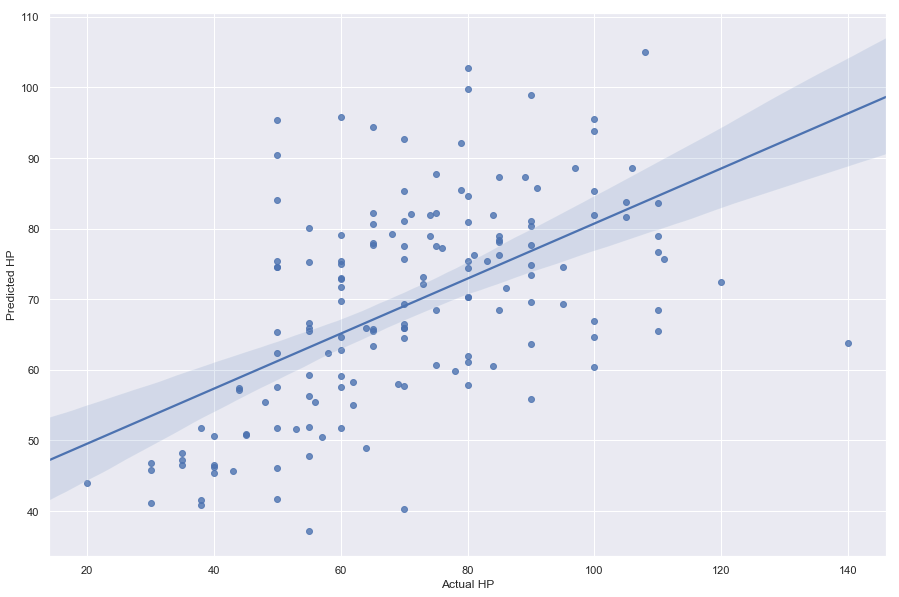

In [28]:
sns.set(rc={'figure.figsize':(15,10)})
actual_hp, pred_hp = pd.Series(y_test, name="Actual HP"), pd.Series(y_pred_enet, name="Predicted HP")
ax = sns.regplot(x=actual_hp, y=pred_hp, data=df)

# Additional Code

For future work, I'll be trying more Ridge Regression/ElasticNet to minimize the RMSE

In [29]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=50)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_test, y_test):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression val R^2: 0.288
Ridge Regression val R^2: 0.290
Degree 2 polynomial regression val R^2: 0.341


In [31]:
from sklearn.model_selection import KFold

X, y = df.drop('HP',axis=1), df['HP']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [32]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.425395909701477, 0.3467414356530166, 0.34195837044569255, 0.4133756562017734, 0.4001216867058772]
Ridge scores:  [0.4251727496856861, 0.34708721941942333, 0.34196083086286977, 0.41336483569481264, 0.4001734059906632] 

Simple mean cv r^2: 0.386 +- 0.035
Ridge mean cv r^2: 0.386 +- 0.034


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: D

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.288


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
